In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import matplotlib.dates   as mdates


df = pd.read_csv(
    'data/analysis_data/merged_data_US.csv',
    parse_dates=['month']
)
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(' ', '_')
)

In [ ]:
def exo_ARIMAX_forecast_period(state, start_year, end_year, corr_threshold=0.1):
    sub = df[df.state == state].copy()
    sub['month'] = pd.to_datetime(sub['month'])
    sub = sub.set_index('month')

    train = sub[sub.index < f'{start_year}-01-01']
    test  = sub[(sub.index >= f'{start_year}-01-01') & (sub.index < f'{end_year+1}-01-01')]
    if len(test)==0:
        print(f"No data for {state} {start_year}-{end_year}.")
        return

    y_train = train.unemployment_rate
    y_test  = test.unemployment_rate

    exog_vars = ['median_income', 'initial_claims', 'population', 'lfp_rate']

    corr = train[exog_vars + ['unemployment_rate']].corr()['unemployment_rate'].drop('unemployment_rate')
    print("Training correlations with unemployment_rate:\n", corr)

    selected = corr[ corr.abs() >= corr_threshold ].index.tolist()
    print(f"\nDropping vars with |corr| < {corr_threshold}:", 
          [v for v in exog_vars if v not in selected])
    print("Using exogenous predictors:", selected)

    if not selected:
        raise ValueError("No exogenous variables pass the correlation threshold. "
                         "Try lowering corr_threshold.")

    X_train = train[selected]
    X_test  = test[selected]

    arimax = pm.auto_arima(
        y=y_train,
        exogenous=X_train,
        seasonal=True, m=12,
        start_p=0, max_p=3, start_q=0, max_q=3,
        d=None, D=None,
        trace=True,
        error_action='ignore',
        suppress_warnings=True
    )

    fc, confint = arimax.predict(n_periods=len(y_test), exogenous=X_test, return_conf_int=True)
    mse  = mean_squared_error(y_test, fc)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_test, fc)
    print(f"{state} ARIMAX {start_year}-{end_year} → RMSE: {rmse:.3f}, R²: {r2:.3f}")

    plt.figure(figsize=(6,5))
    plt.plot(train.index, train.unemployment_rate, label=f'Train (before {start_year})')
    plt.plot(y_test.index,  y_test,  label=f'Actual {start_year}-{end_year}')
    plt.plot(y_test.index,  fc,      label='Forecast')
    plt.fill_between(y_test.index, confint[:,0], confint[:,1], alpha=0.3)
    plt.title(f"{state} Unemployment ARIMAX Forecast ({start_year}–{end_year})")
    plt.xlabel("Month"); plt.ylabel("Unemployment Rate (%)")
    plt.legend()
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator(base=3))   # ticks every 3rd year
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

Training correlations with unemployment_rate:
 median_income    -0.088657
initial_claims    0.476905
population       -0.110702
lfp_rate         -0.297519
Name: unemployment_rate, dtype: float64

Dropping vars with |corr| < 0.1: ['median_income']
Using exogenous predictors: ['initial_claims', 'population', 'lfp_rate']
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=-606.147, Time=3.26 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-598.190, Time=0.24 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-892.713, Time=1.89 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-732.950, Time=1.89 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-596.338, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-889.014, Time=0.37 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-891.053, Time=4.76 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-891.457, Time=2.55 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-893.094, Time=1.96 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept

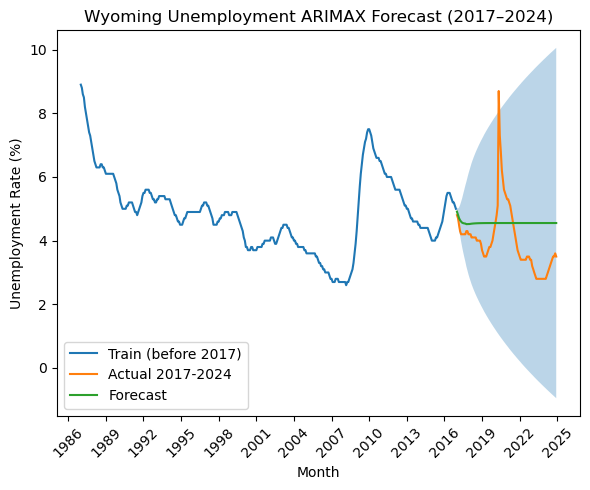

In [28]:
exo_ARIMAX_forecast_period('Wyoming', 2017, 2024)

Training correlations with unemployment_rate:
 median_income    -0.518487
initial_claims    0.126233
population       -0.379635
lfp_rate         -0.681055
Name: unemployment_rate, dtype: float64

Dropping vars with |corr| < 0.1: []
Using exogenous predictors: ['median_income', 'initial_claims', 'population', 'lfp_rate']
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=-1027.342, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-1031.339, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-1054.073, Time=0.58 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-1044.978, Time=1.22 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-1028.866, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-1056.069, Time=0.33 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-1054.073, Time=0.77 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-1052.070, Time=1.49 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=-1078.824, Time=0.46 sec
 ARIMA(2,1,0)(1,0,0)[12

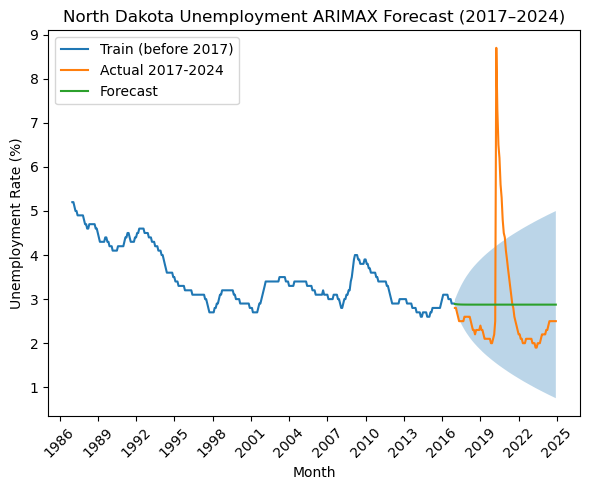

In [29]:
exo_ARIMAX_forecast_period('North Dakota', 2017, 2024)

Training correlations with unemployment_rate:
 median_income    -0.407306
initial_claims    0.478316
population       -0.198611
lfp_rate          0.055649
Name: unemployment_rate, dtype: float64

Dropping vars with |corr| < 0.1: ['lfp_rate']
Using exogenous predictors: ['median_income', 'initial_claims', 'population']
Performing stepwise search to minimize aic


 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=467.215, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=463.233, Time=0.19 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=459.411, Time=0.40 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=460.779, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=461.809, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=457.436, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=459.410, Time=0.38 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=461.378, Time=2.05 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=458.583, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=459.308, Time=0.54 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=458.803, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=444.424, Time=0.43 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=446.336, Time=1.23 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=446.333, Time=1.29 sec
 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=448.269, Time=2.07 sec
 ARIMA(3,1

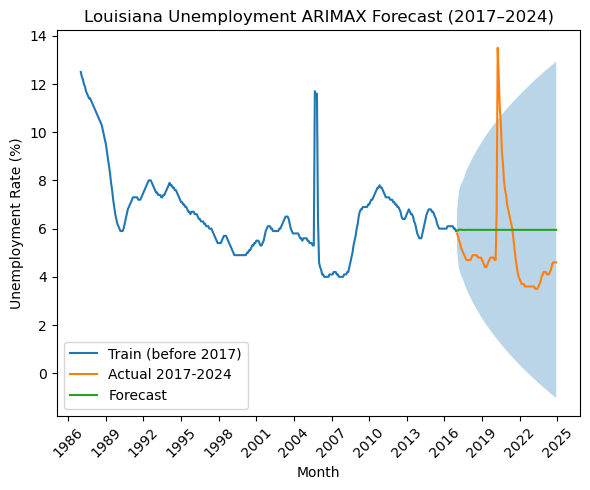

In [30]:
exo_ARIMAX_forecast_period('Louisiana', 2017, 2024)

Training correlations with unemployment_rate:
 median_income    -0.365916
initial_claims    0.236559
population       -0.140887
lfp_rate         -0.101295
Name: unemployment_rate, dtype: float64

Dropping vars with |corr| < 0.1: []
Using exogenous predictors: ['median_income', 'initial_claims', 'population', 'lfp_rate']
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=-733.454, Time=1.32 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-731.613, Time=0.17 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-905.143, Time=1.03 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-817.770, Time=0.81 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-725.549, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-905.009, Time=0.20 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-903.143, Time=2.87 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-903.143, Time=0.93 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-905.129, Time=1.07 sec
 ARIMA(1,1,0)(2,0,1)[12] interce

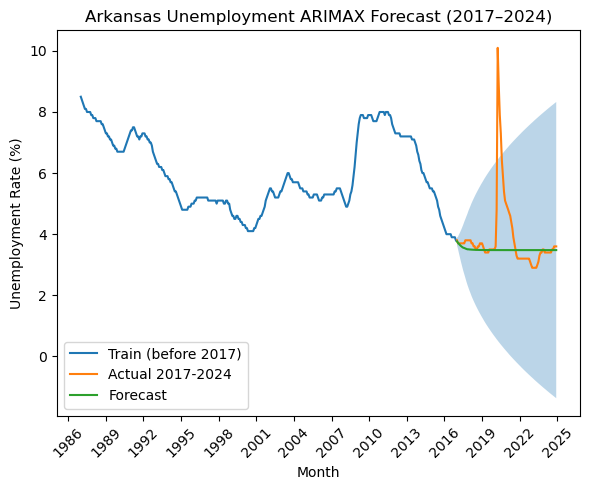

In [31]:
exo_ARIMAX_forecast_period('Arkansas', 2017, 2024)

Training correlations with unemployment_rate:
 median_income    -0.518487
initial_claims    0.126233
population       -0.379635
lfp_rate         -0.681055
Name: unemployment_rate, dtype: float64

Dropping vars with |corr| < 0.1: []
Using exogenous predictors: ['median_income', 'initial_claims', 'population', 'lfp_rate']
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=-1027.342, Time=1.18 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-1031.339, Time=0.38 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-1054.073, Time=1.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-1044.978, Time=1.91 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-1028.866, Time=0.72 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-1056.069, Time=0.73 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-1054.073, Time=0.84 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-1052.070, Time=1.74 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=-1078.824, Time=0.51 sec
 ARIMA(2,1,0)(1,0,0)[12

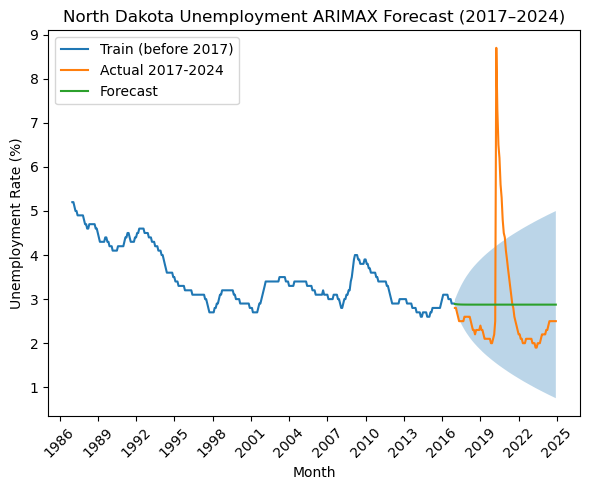

In [32]:
exo_ARIMAX_forecast_period('North Dakota', 2017, 2024)

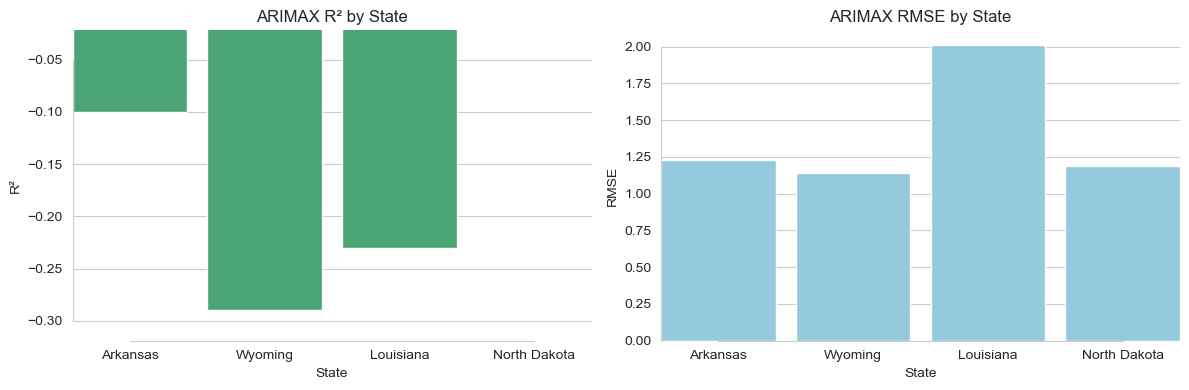

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

rep_states = ["Arkansas", "Wyoming", "Louisiana", "North Dakota"]
r2_dict   = {"Arkansas": -0.10, "Wyoming": -0.29, "Louisiana": -0.23, "North Dakota": -0.02}
rmse_dict = {"Arkansas": 1.23,  "Wyoming": 1.14,  "Louisiana": 2.01,  "North Dakota": 1.19}

df_metrics = pd.DataFrame({
    "state": rep_states,
    "r2":    [r2_dict[s] for s in rep_states],
    "rmse":  [rmse_dict[s] for s in rep_states],
})

sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

# R² chart
sns.barplot(
    data=df_metrics,
    x="state", y="r2",
    color="mediumseagreen",
    width=0.85,
    ax=axes[0]
)

ymin = df_metrics["r2"].min() * 1.1
ymax = df_metrics["r2"].max() * 1.1
axes[0].set_ylim(ymin, ymax)

axes[0].set_title("ARIMAX R² by State")
axes[0].set_xlabel("State")
axes[0].set_ylabel("R²")
axes[0].tick_params(axis="x", rotation=0)
axes[0].margins(x=0)
sns.despine(trim=True, ax=axes[0])

# RMSE chart
sns.barplot(
    data=df_metrics,
    x="state", y="rmse",
    color="skyblue",
    width=0.85,
    ax=axes[1]
)
axes[1].set_title("ARIMAX RMSE by State")
axes[1].set_xlabel("State")
axes[1].set_ylabel("RMSE")
axes[1].tick_params(axis="x", rotation=0)
axes[1].margins(x=0)
sns.despine(trim=True, ax=axes[1])

plt.tight_layout()
plt.show()
